In [1]:
import torch
torch.cuda.empty_cache()


In [2]:
from dentsegdataset import *

In [3]:
#Training from a saved model
#Specify run used to create original model to continue training
kw_dict = {
    'epochs':400,
    'load_model':True,
    'eval':True,
    'full_model':True,
    'flat':True,
    #'model_name':'ckpt',
    'dataset_path':'/dentseg/app/dataset',
    'image_size':128,
    'lossfunc':'DISCLOSS',
    'lr':5e-5,
    'in_c':1,
    'out_c':32,
    'run_name':'DentSeg_sa_multi', 
    'batch_size':5,
    'sa':True,
    'ghost':False,
}
model, output = launch(**kw_dict)

  5%|▌         | 1/19 [00:02<00:50,  2.82s/it, IOU=0.46] 

test loss: 0.4767693281173706
test loss: 0.3508542776107788
test loss: 0.4601120352745056


 21%|██        | 4/19 [00:03<00:11,  1.28it/s, IOU=0.474]

test loss: 0.47366952896118164


 26%|██▋       | 5/19 [00:04<00:11,  1.25it/s, IOU=0.459]

test loss: 0.4587348699569702


 32%|███▏      | 6/19 [00:05<00:10,  1.22it/s, IOU=0.415]

test loss: 0.41520214080810547


 37%|███▋      | 7/19 [00:06<00:09,  1.21it/s, IOU=0.469]

test loss: 0.4692947268486023


 42%|████▏     | 8/19 [00:07<00:09,  1.20it/s, IOU=0.411]

test loss: 0.41082143783569336


 47%|████▋     | 9/19 [00:08<00:08,  1.19it/s, IOU=0.409]

test loss: 0.4093514680862427


 53%|█████▎    | 10/19 [00:08<00:07,  1.18it/s, IOU=0.504]

test loss: 0.5044186115264893


 58%|█████▊    | 11/19 [00:09<00:06,  1.17it/s, IOU=0.394]

test loss: 0.39388513565063477


 63%|██████▎   | 12/19 [00:10<00:05,  1.17it/s, IOU=0.321]

test loss: 0.32060861587524414


 68%|██████▊   | 13/19 [00:11<00:05,  1.17it/s, IOU=0.496]

test loss: 0.4962443709373474


 74%|███████▎  | 14/19 [00:12<00:04,  1.17it/s, IOU=0.47] 

test loss: 0.4699863791465759


 79%|███████▉  | 15/19 [00:13<00:03,  1.17it/s, IOU=0.487]

test loss: 0.4872763156890869


 84%|████████▍ | 16/19 [00:14<00:02,  1.17it/s, IOU=0.473]

test loss: 0.4733693599700928


 89%|████████▉ | 17/19 [00:14<00:01,  1.17it/s, IOU=0.465]

test loss: 0.46543288230895996


 95%|█████████▍| 18/19 [00:15<00:00,  1.17it/s, IOU=0.37] 

test loss: 0.3704988956451416


100%|██████████| 19/19 [00:16<00:00,  1.14it/s, IOU=0.342]

test loss: 0.34189170598983765
mean loss: 0.43412750645687703


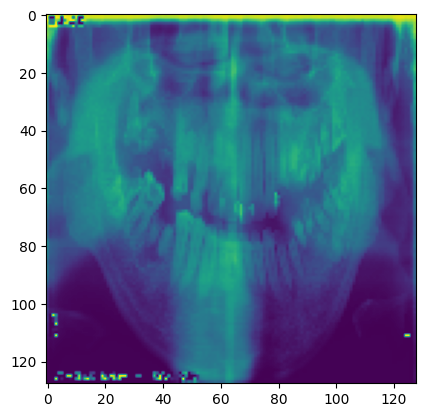

In [4]:
plt.imshow(output[16][0][3][0])

In [5]:
(logistic.cdf(output[15][2][3][20])>0.5).astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

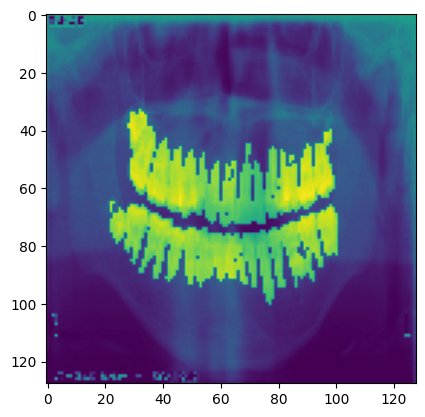

In [44]:
plt.imshow(output[16][0][3][0] + np.sum((logistic.cdf(output[16][2][3])>0.5).astype(int),axis=0).astype(bool))

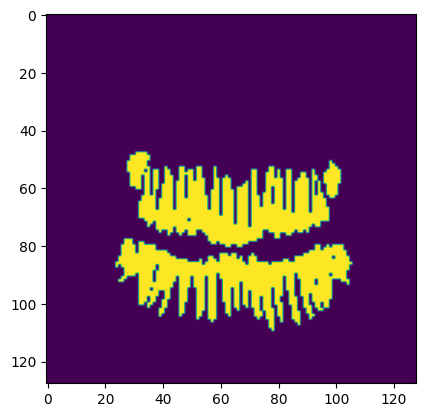

In [55]:
plt.imshow(np.sum(logistic.cdf(output[16][1][3]),axis=0)>16)

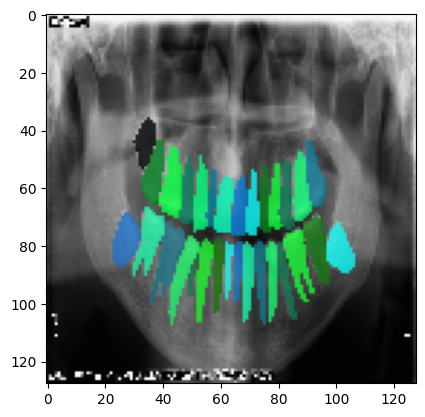

In [44]:
def apply_colored_mask(image, masks, threshold=0.5):
    """
    Applies multiple masks to an image, each in a specified color.
    
    Parameters:
    - image: The original grayscale image.
    - masks: A list of masks to apply.
    - colors: A list of colors corresponding to each mask.
    - threshold: The threshold for applying the masks.
    
    Returns:
    - The image with colored masks applied.
    """
    # Ensure the image is in RGBA to overlay colors
    
    colored_image = cv2.cvtColor(image*255,cv2.COLOR_GRAY2RGB)
    colored_image = torch.tensor(colored_image).detach().cpu().type(torch.uint8).permute(2,0,1)
    seg_mask = torch.tensor(logistic.cdf(masks)>threshold).detach().cpu()
    colored_image = draw_segmentation_masks(colored_image,seg_mask)
    return colored_image.permute(1,2,0).numpy()

test_image = apply_colored_mask(output[0][0][2][0],output[0][1][2])
plt.imshow(test_image)


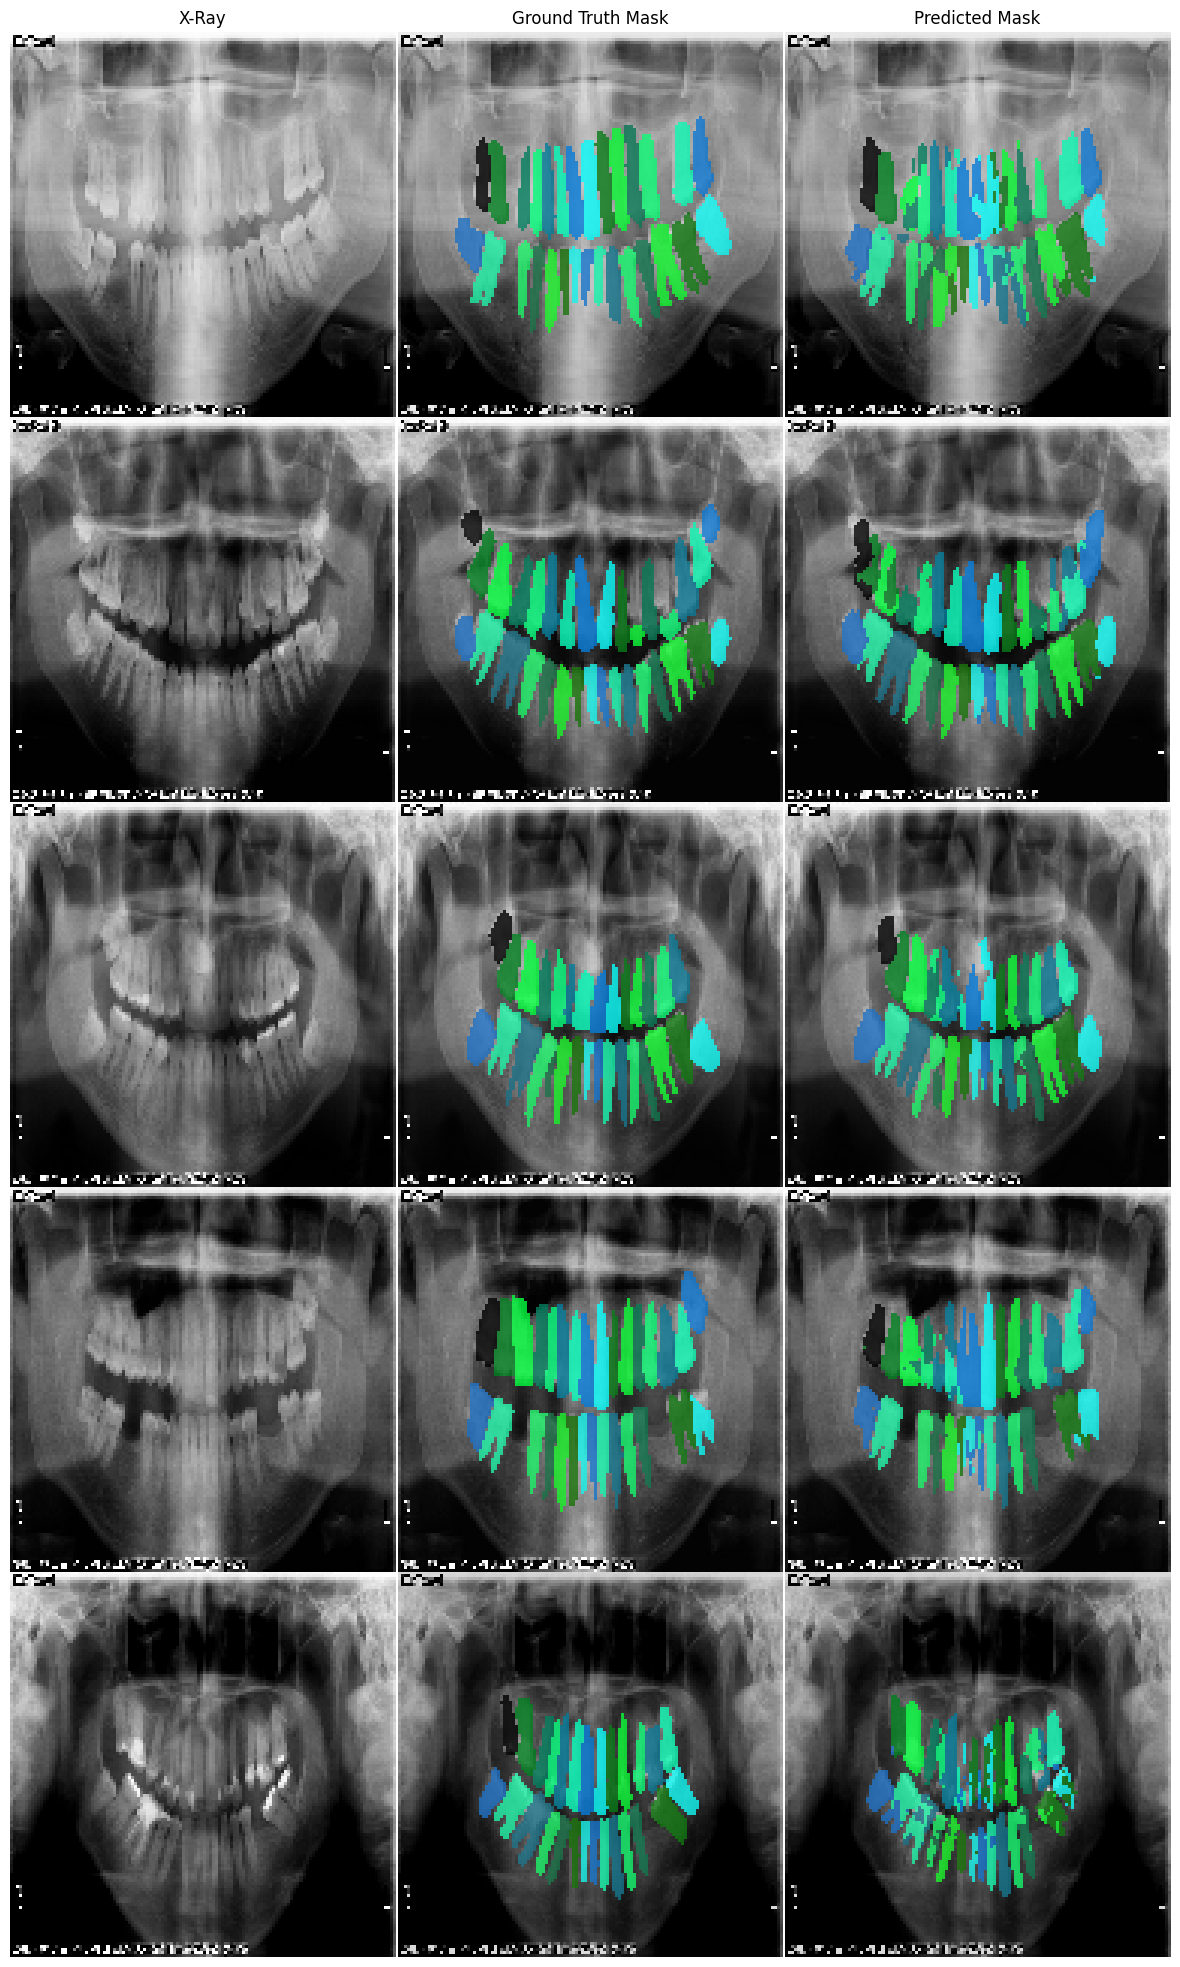

In [50]:
def display_results(data, batch_no:int):
    """
    Displays an X-ray image with ground truth and predicted masks color-coded and overlaid.
    
    Parameters:
    - data: A tuple containing the datasets (X-rays, ground truth masks, predicted masks).
    - batch_no: The index of the image to display.
    """
    
    
    x_ray_images, ground_truth_masks, predicted_masks = data[batch_no]
    num_sets = len(data[0][0])
    fig, axs = plt.subplots(num_sets, 3, figsize=(15, 5*num_sets))
    
    # Remove the gap between images
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for i in range(num_sets):
        # Plot X-Ray
        axs[i, 0].imshow(x_ray_images[i][0], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title('X-Ray' if i == 0 else "")

        # Plot Ground Truth Mask
        axs[i, 1].imshow(apply_colored_mask(x_ray_images[i][0],ground_truth_masks[i]))
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Ground Truth Mask' if i == 0 else "")

        # Plot Predicted Mask
        axs[i, 2].imshow(apply_colored_mask(x_ray_images[i][0],predicted_masks[i]))
        axs[i, 2].axis('off')
        axs[i, 2].set_title('Predicted Mask' if i == 0 else "")
    
    # Show the plot
    plt.show()

display_results(output,0)


In [40]:
torch.tensor(output[0][0][0][0])

tensor([[0.9843, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9882],
        [0.9961, 0.1529, 0.0118,  ..., 0.9804, 0.9725, 0.9882],
        [0.9804, 0.0118, 1.0000,  ..., 0.9176, 0.9333, 0.9294],
        ...,
        [0.0118, 0.7098, 0.0118,  ..., 0.0078, 0.0196, 0.1137],
        [0.0118, 1.0000, 1.0000,  ..., 0.0078, 0.0157, 0.1059],
        [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0157, 0.0941]])

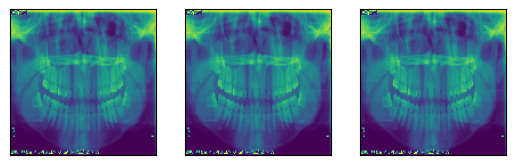

In [43]:
grid = make_grid(torch.tensor(output[0][0][0][0]))
len(grid)
show(list(grid))